In [44]:
# As input : path of model, path of data 

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyfasttext import FastText
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
from collections import Counter
import math
import json
import pandas as pd

In [46]:
class EmbeddingsProbe:
    
    def get_lexicons(self, DATAPATH):
        '''Reads file and returns Counter object of data'''
        lang_data = open(DATAPATH, "r").read()
        lang_lexicon = Counter(lang_data.split())
        lang_total = len(lang_data)

        return lang_lexicon, lang_total
    
    def read_bl(self, PATH):
        
        with open(PATH, "r") as f:
            return json.load(f)

    def get_frequency_threshold(self, lang_lexicon):
        '''Logarithmic freq threshold'''

        total = sum(lang_lexicon.values())
        return math.log(total, 100) - 1


    def find_lang(self, word, lang2_lexicon, lang2_threshold):
        '''Returns 1 if word exists in other lang with respectable freq'''
        if lang2_lexicon[word] >= lang2_threshold:
#         if lang2_lexicon[word]:
            return 1
        return 0

    def find_integration(self, model, lang1_lexicon, lang2_lexicon, sample_len=100, K=10):
        '''Chooses sample words, finds NNs, returns avg. of crosslingual neighbours
        This number is b/w 0 and 1'''
        samples = random.choices(list(lang1_lexicon.keys()), \
                                 weights = list(lang1_lexicon.values()), k=sample_len)

        avg_int = 0
        lang2_threshold = self.get_frequency_threshold(lang2_lexicon)
        for sample in samples:
            nns = model.nearest_neighbors(sample, k = K)
#             print(nns)
            norm = sum([nn[1] for nn in nns])
            avg_int += sum([self.find_lang(nn[0], lang2_lexicon, lang2_threshold)*nn[1] for nn in nns])/norm

        avg_int /= len(samples)

        return avg_int 
    
    def find_bl_recall_at_k(self, model, bil_lex, K = 10):
        '''Finds R@K for bilingual lexicon with source as lang1, target as lang2'''
        
        rec_at_k = 0

        for idx, (source, target) in enumerate(list(bil_lex.items())):
            nns = model.nearest_neighbors(source, k = K)
            if target in [nn[0] for nn in nns]:
                rec_at_k += 1
            
            if idx and idx % 100 == 0:
                print(idx, rec_at_k/idx)
        
        rec_at_k /= len(bil_lex)
        return rec_at_k
    
    def plot_bl_rec_by_k(self, model, bil_lex):
        
        X, Y = list(), list()
        for k in range(10, 110, 10):
            X.append(k)
            Y.append(self.find_bl_recall_at_k(model, bil_lex, K=k))
        
        return X, Y
            
                     
        

    def driver(self, LANG_PATH, ANCH_PATH,  MODEL, BL_PATH = None):
        '''Runs all tests'''
        
        results = dict()

        lang_lexicon, lang_total = self.get_lexicons(LANG_PATH)
        anch_lexicon, anch_total = self.get_lexicons(ANCH_PATH)

        if isinstance(MODEL, str):
            model = FastText(MODEL_PATH)

        integ_12 = self.find_integration(model, lang_lexicon, anch_lexicon)
        integ_21 = self.find_integration(model, anch_lexicon, lang_lexicon)
        results["integ_12"] = integ_12
        results["integ_21"] = integ_21
        
        if BL_PATH:
            bil_lex = self.read_bl(BL_PATH)
            bl_21 = self.find_bl_recall_at_k(model, bil_lex, K=50)
            bil_lex_12 = {target:source for source, target in bil_lex.items()}
            bl_12 = self.find_bl_recall_at_k(model, bil_lex_12, K=50)
            
            results["bl_12"] = bl_12
            results["bl_21"] = bl_21

        return results






In [50]:
langs = [
"sindhi",
"rajasthani",
"punjabi",
"hariyanvi",
# "gujarati",
"khadi_boli",
"sanskrit",
# "hindi-urdu",
"bhil",
"koraku",
"baiga",
"nimaadi",
"malwi",
"marathi",
"bhadavari",
"himachali",
"garwali",
"kumaoni",
"kannauji",
"brajbhasha",
"bundeli",
"awadhi",
"chattisgarhi",
"nepali",
"pali",
"bhojpuri",
"bajjika",
"magahi",
"maithili",
"angika",
# "bangla"
        ]

In [51]:
# PATH to tokenized data

PATH = "../../data/upsampled/"
anchor = "hindi-urdu"
ANCH_PATH = PATH + anchor + ".txt"

all_results = dict()

obj = EmbeddingsProbe()
# BL_PATH = "bilingual_lexicon_tests/hindi2nepali_bornates.json"
for lang in langs:
    LANG_PATH = PATH + lang + ".txt"
    MODEL_PATH = "../models/upsampled/{}_{}.bin".format(lang, anchor)
    all_results[lang] = obj.driver(LANG_PATH, ANCH_PATH, MODEL_PATH)


In [52]:
all_r_results = dict()
for lang in all_results:
    all_r_results[lang] = {k: round(v, 2) for k, v in all_results[lang].items()}

In [53]:
df = pd.DataFrame(all_r_results).transpose()
print(df.to_latex(caption = "Integration values for all languages", label= "integ_all"))

\begin{table}
\centering
\caption{Integration values for all languages}
\label{integ_all}
\begin{tabular}{lrr}
\toprule
{} &  integ\_12 &  integ\_21 \\
\midrule
sindhi       &      0.31 &      0.33 \\
rajasthani   &      0.62 &      0.40 \\
punjabi      &      0.40 &      0.27 \\
hariyanvi    &      0.66 &      0.36 \\
khadi\_boli   &      0.76 &      0.13 \\
sanskrit     &      0.12 &      0.26 \\
bhil         &      0.53 &      0.34 \\
koraku       &      0.34 &      0.10 \\
baiga        &      0.73 &      0.31 \\
nimaadi      &      0.47 &      0.21 \\
malwi        &      0.45 &      0.13 \\
marathi      &      0.32 &      0.15 \\
bhadavari    &      0.81 &      0.30 \\
himachali    &      0.48 &      0.07 \\
garwali      &      0.25 &      0.39 \\
kumaoni      &      0.74 &      0.05 \\
kannauji     &      0.66 &      0.14 \\
brajbhasha   &      0.74 &      0.38 \\
bundeli      &      0.58 &      0.36 \\
awadhi       &      0.45 &      0.43 \\
chattisgarhi &      0.51 &      0.36 \

In [54]:
with open("integration_upsampled_all.json", "w") as f:
    json.dump(all_r_results, f, indent=2)

In [26]:
# Do for Nep splits
results_data = dict()

lang = "nepali"
anchor = "hindi-urdu"

for data_size in [5000, 50000, 100000, 500000]:

    LANG_PATH = "../../data/crawled_nep_splits/nepali_{}.txt".format(data_size)
    ANCH_PATH = "../../data/crawled_cleaned/hindi-urdu.txt"
    MODEL_PATH = "../models/joint_nep_splits/nepali_{}_hindi-urdu.bin".format(data_size)
    BL_PATH = "bilingual_lexicon_tests/hindi2nepali_bornates.json"


    obj = EmbeddingsProbe()
    results_data[data_size] = obj.driver(LANG_PATH, ANCH_PATH, MODEL_PATH, BL_PATH)




In [55]:
# Results for upsampled Nepali

LANG_PATH = "../../data/upsampled/nepali.txt"
ANCH_PATH = "../../data/crawled_cleaned/hindi-urdu.txt"
MODEL_PATH = "../models/upsampled/nepali_hindi-urdu.bin"
BL_PATH = "bilingual_lexicon_tests/hindi2nepali_bornates.json"

obj = EmbeddingsProbe()
results_data = obj.driver(LANG_PATH, ANCH_PATH, MODEL_PATH, BL_PATH)



In [60]:
df = pd.DataFrame({"nep":results_data}).transpose()
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  bl\_12 &  bl\_21 &  integ\_12 &  integ\_21 \\
\midrule
nep &   0.33 &   0.15 &  0.286857 &   0.42345 \\
\bottomrule
\end{tabular}



In [27]:
df = pd.DataFrame(results_data).transpose()
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  integ\_12 &  integ\_21 &  bl\_12 &  bl\_21 \\
\midrule
5000   &  0.425558 &  0.370869 &   0.30 &   0.21 \\
50000  &  0.329890 &  0.377868 &   0.29 &   0.21 \\
100000 &  0.290560 &  0.374815 &   0.29 &   0.20 \\
500000 &  0.331483 &  0.436945 &   0.29 &   0.20 \\
\bottomrule
\end{tabular}



In [57]:
with open("bilingual_test_results/nepali_upsampled_integ_bl.json", "w") as f:
    json.dump(results_data, f, indent = 2)

In [51]:
obj = EmbeddingsProbe()
X, Y = obj.plot_bl_rec_by_k(model, bil_lex)


    

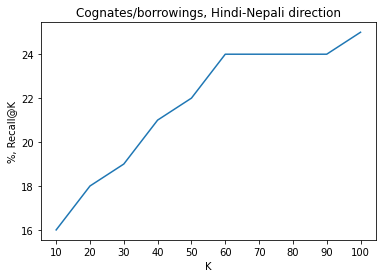

In [59]:
# Y = [y*100 for y in Y]
plt.plot(X, Y)
plt.xlabel("K")
plt.xticks(ticks=X)
plt.ylabel("%, Recall@K")
plt.title("Cognates/borrowings, Hindi-Nepali direction")
plt.savefig("bilingual_test_results/hin2nep_bornates_5M.png")

In [53]:
lang_lexicon, lang_total = obj.get_lexicons(LANG_PATH)

In [54]:
lang_total

4121749

In [31]:
lang_lexicon, lang_total = obj.get_lexicons(LANG_PATH)
anch_lexicon, anch_total = obj.get_lexicons(ANCH_PATH)
model = FastText(MODEL_PATH)
lang, anch = 0, 0
for word in model.words:
    if word in lang_lexicon:
        lang += 1
    if word in anch_lexicon:
        anch += 1
print(lang, anch)

8691 49186


In [28]:
print(rec_at_k)

0.16


In [30]:
print(rec_at_k)

0.18


In [32]:
print(rec_at_k)

0.22


In [32]:
len(lang_lexicon)

16942

In [37]:
min_freq = min([lang_lexicon[word] for word in model.words if word in lang_lexicon])

In [38]:
min_freq

1

In [43]:
mwords = set(model.words)
max_freq = max([lang_lexicon[word] for word in lang_lexicon if word not in mwords])

In [44]:
len(model.words)

49591

In [45]:
max_freq

4

In [48]:
all_words = set(lang_lexicon.keys()).union(set(anch_lexicon.keys()))
all_lexicon = {word:lang_lexicon[word] + anch_lexicon[word] for word in all_words}

In [49]:
min_freq = min([all_lexicon[word] for word in model.words])

In [50]:
min_freq

5

hey
